In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import string
import joblib
import warnings

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, HistGradientBoostingRegressor
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#Directory to save the results 
datas = os.path.expanduser('~/Desktop/Dissertation/datas')

if not os.path.exists(datas):
    os.makedirs(datas)

In [3]:
#Directory to save the plots 
plots = os.path.expanduser('~/Desktop/Dissertation/plots')

if not os.path.exists(plots):
    os.makedirs(plots)

In [4]:
base_dir = os.getcwd()

def get_file_path(file_name):
    return os.path.join(base_dir, file_name)

# Reading the CSV files using the constructed paths
May_all_trends = pd.read_csv(get_file_path('2021_May_all_trends_data.csv'))
May_hashtag_trend = pd.read_csv(get_file_path('2021_May_hashtag_trend_data.csv'))
May_twitter_trending = pd.read_csv(get_file_path('2021_May_twitter_trending_data.csv'))

June_all_trends = pd.read_csv(get_file_path('2021_June_all_trends_data.csv'))
June_hashtag_trend = pd.read_csv(get_file_path('2021_June_hashtag_trend_data.csv'))
June_twitter_trending = pd.read_csv(get_file_path('2021_June_twitter_trending_data.csv'))

July_all_trends = pd.read_csv(get_file_path('2021_July_all_trends_data.csv'))
July_hashtag_trend = pd.read_csv(get_file_path('2021_July_hashtag_trend_data.csv'))
July_twitter_trending = pd.read_csv(get_file_path('2021_July_twitter_trending_data.csv'))

August_all_trends = pd.read_csv(get_file_path('2021_August_all_trends_data.csv'))
August_hashtag_trend = pd.read_csv(get_file_path('2021_August_hashtag_trend_data.csv'))
August_twitter_trending = pd.read_csv(get_file_path('2021_August_twitter_trending_data.csv'))

September_all_trends = pd.read_csv(get_file_path('2021_September_all_trends_data.csv'))
September_hashtag_trend = pd.read_csv(get_file_path('2021_September_hashtag_trend_data.csv'))

chunks = []
chunk_size = 10000
with open(get_file_path('2021_September_twitter_trending_data.csv'), 'r', encoding='utf-8') as file:
    for chunk in pd.read_csv(file, chunksize=chunk_size, low_memory=False):
        chunks.append(chunk)
September_twitter_trending = pd.concat(chunks, ignore_index=True)

October_all_trends = pd.read_csv(get_file_path('2021_October_all_trends_data.csv'))
October_hashtag_trend = pd.read_csv(get_file_path('2021_October_hashtag_trend_data.csv'))
October_twitter_trending = pd.read_csv(get_file_path('2021_October_twitter_trending_data.csv'))


/var/folders/_6/0nvv1lhn0gz1q__7mdvsvws00000gn/T/ipykernel_18406/367250910.py:13: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  June_twitter_trending = pd.read_csv(get_file_path('2021_June_twitter_trending_data.csv'))


In [5]:
#loading the csv files 
all_trends = pd.concat(
    [May_all_trends, June_all_trends, July_all_trends, August_all_trends, September_all_trends, October_all_trends],
    ignore_index=True)
hashtag_trends = pd.concat(
    [May_hashtag_trend, June_hashtag_trend, July_hashtag_trend, August_hashtag_trend, September_hashtag_trend,
     October_hashtag_trend], ignore_index=True)
twitter_trending = pd.concat(
    [May_twitter_trending, June_twitter_trending, July_twitter_trending, August_twitter_trending,
     September_twitter_trending, October_twitter_trending], ignore_index=True)

In [6]:
all_trends.head()

,trend_name,trend_url,trend_query,tweet_volume,searched_at_datetime,searched_in_country
0,#4corners,http://twitter.com/search?q=%234corners,%234corners,NaN,2021-05-24 16:10:20.845908,Australia
1,#couchpeloton,http://twitter.com/search?q=%23couchpeloton,%23couchpeloton,NaN,2021-05-24 16:10:20.845908,Australia
2,#Eternals,http://twitter.com/search?q=%23Eternals,%23Eternals,160462.0,2021-05-24 16:10:20.845908,Australia
3,Gemma Chan,http://twitter.com/search?q=%22Gemma+Chan%22,%22Gemma+Chan%22,NaN,2021-05-24 16:10:20.845908,Australia
4,#PanVisibilityDay,http://twitter.com/search?q=%23PanVisibilityDay,%23PanVisibilityDay,14413.0,2021-05-24 16:10:20.845908,Australia


In [7]:
hashtag_trends.head()

,trend_name,trend_url,trend_query,tweet_volume,searched_at_datetime,searched_in_country
0,#4corners,http://twitter.com/search?q=%234corners,%234corners,NaN,2021-05-24 16:10:20.845908,Australia
1,#couchpeloton,http://twitter.com/search?q=%23couchpeloton,%23couchpeloton,NaN,2021-05-24 16:10:20.845908,Australia
2,#Eternals,http://twitter.com/search?q=%23Eternals,%23Eternals,160462.0,2021-05-24 16:10:20.845908,Australia
3,#PanVisibilityDay,http://twitter.com/search?q=%23PanVisibilityDay,%23PanVisibilityDay,14413.0,2021-05-24 16:10:20.845908,Australia
4,#Giro,http://twitter.com/search?q=%23Giro,%23Giro,25718.0,2021-05-24 16:10:20.845908,Australia


In [8]:
twitter_trending.head()

,tweet_id,tweet_datetime,tweet_hashtags,tweet_language,retweet_count,tweet_source,tweet_source_url,tweet_text,user_created_datetime,user_name,user_followers_count,user_description,user_location,searched_by_hashtag,searched_at_datetime,searched_hashtag_country
0,1396861171894943752,2021-05-24 16:10:30,AstraZenaca,en,13,Twitter for iPhone,http://twitter.com/download/iphone,RT @14luxor: @beer_nun With political and comm...,2009-03-12 05:38:12,Gibbsy,1720.0,"Teacher, mother, still a hippie at heart & alw...",Sydney Australia,#4corners,2021-05-24 16:10:20.845908,Australia
1,1396861133034639360,2021-05-24 16:10:21,NaN,en,0,Twitter for Android,http://twitter.com/download/android,"It starts and end with you, Brendan Murphy. Yo...",2015-12-12 03:56:35,Chris Lancashire,2863.0,Author #BeyondCourage: Memoir of my son #Andre...,NaN,#4corners,2021-05-24 16:10:20.845908,Australia
2,1396860881191915522,2021-05-24 16:09:21,NaN,en,36,Twitter for iPad,http://twitter.com/#!/download/ipad,RT @james00000001: If domestic production of v...,2009-07-01 01:51:23,Jacqueline Lee Lewes,2300.0,Journalist once. Unionist. Feminist. Howling m...,NaN,#4corners,2021-05-24 16:10:20.845908,Australia
3,1396860808076795908,2021-05-24 16:09:03,NaN,en,46,Twitter for Android,http://twitter.com/download/android,RT @PRGuy17: Instead of hiring and consulting ...,2020-10-05 08:58:43,🕯🐀Debbie Bella 🐭 Proud Sewer Rat🐁 🕯,345.0,#IStandWithDanAndrews and #IStandWithBrett\n#I...,Eagle Point,#4corners,2021-05-24 16:10:20.845908,Australia
4,1396860638400368643,2021-05-24 16:08:23,"4Corners, auspol",en,10,Twitter for Android,http://twitter.com/download/android,RT @deniseshrivell: How's the mainstream media...,2011-10-29 11:40:54,🐕🐱🦅🌏🏝 ResistenceinOzWendy Ellliott,1911.0,"Animal Rights, Business Development, Community...","Queensland, Australia",#4corners,2021-05-24 16:10:20.845908,Australia


In [9]:
#Data Cleaning

In [10]:
nan_counts = all_trends.isna().sum()

print(nan_counts)

trend_name                 0
trend_url                  0
trend_query                0
tweet_volume            6942
searched_at_datetime       0
searched_in_country        0
dtype: int64


In [11]:
nan_counts = hashtag_trends.isna().sum()

print(nan_counts)

trend_name                 0
trend_url                  0
trend_query                0
tweet_volume            1347
searched_at_datetime       0
searched_in_country        0
dtype: int64


In [12]:
nan_counts = twitter_trending.isna().sum()

print(nan_counts)

tweet_id                         0
tweet_datetime                   6
tweet_hashtags               39742
tweet_language                   6
retweet_count                    6
tweet_source                 82826
tweet_source_url             82825
tweet_text                   82825
user_created_datetime        82827
user_name                    82839
user_followers_count         82829
user_description            111538
user_location               147993
searched_by_hashtag          82835
searched_at_datetime         82835
searched_hashtag_country     82835
dtype: int64


In [13]:
print(all_trends.dtypes)
print(hashtag_trends.dtypes)
print(twitter_trending.dtypes)

trend_name               object
trend_url                object
trend_query              object
tweet_volume            float64
searched_at_datetime     object
searched_in_country      object
dtype: object
trend_name               object
trend_url                object
trend_query              object
tweet_volume            float64
searched_at_datetime     object
searched_in_country      object
dtype: object
tweet_id                     object
tweet_datetime               object
tweet_hashtags               object
tweet_language               object
retweet_count                object
tweet_source                 object
tweet_source_url             object
tweet_text                   object
user_created_datetime        object
user_name                    object
user_followers_count        float64
user_description             object
user_location                object
searched_by_hashtag          object
searched_at_datetime         object
searched_hashtag_country     object
dtype: objec

In [14]:
numerical_cols = all_trends.select_dtypes(include=['number']).columns
categorical_cols = all_trends.select_dtypes(include=['object']).columns

iter_imputer = IterativeImputer(random_state=0)

all_trends[numerical_cols] = iter_imputer.fit_transform(all_trends[numerical_cols])

for col in categorical_cols:
    all_trends[col].fillna(all_trends[col].mode()[0], inplace=True)

nan_counts = all_trends.isna().sum()
print(nan_counts)

trend_name              0
trend_url               0
trend_query             0
tweet_volume            0
searched_at_datetime    0
searched_in_country     0
dtype: int64


/var/folders/_6/0nvv1lhn0gz1q__7mdvsvws00000gn/T/ipykernel_18406/603095972.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_trends[col].fillna(all_trends[col].mode()[0], inplace=True)


In [15]:
numerical_cols = hashtag_trends.select_dtypes(include=['number']).columns
categorical_cols = hashtag_trends.select_dtypes(include=['object']).columns

iter_imputer = IterativeImputer(random_state=0)

hashtag_trends[numerical_cols] = iter_imputer.fit_transform(hashtag_trends[numerical_cols])

for col in categorical_cols:
    hashtag_trends[col].fillna(hashtag_trends[col].mode()[0], inplace=True)
    
nan_counts = hashtag_trends.isna().sum()
print(nan_counts)

trend_name              0
trend_url               0
trend_query             0
tweet_volume            0
searched_at_datetime    0
searched_in_country     0
dtype: int64


/var/folders/_6/0nvv1lhn0gz1q__7mdvsvws00000gn/T/ipykernel_18406/224197790.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hashtag_trends[col].fillna(hashtag_trends[col].mode()[0], inplace=True)


In [16]:
numerical_cols = twitter_trending.select_dtypes(include=['number']).columns
categorical_cols = twitter_trending.select_dtypes(include=['object']).columns

iter_imputer = IterativeImputer(random_state=0)

twitter_trending[numerical_cols] = iter_imputer.fit_transform(twitter_trending[numerical_cols])

for col in categorical_cols:
    twitter_trending[col].fillna(twitter_trending[col].mode()[0], inplace=True)

nan_counts = twitter_trending.isna().sum()
print(nan_counts)

/var/folders/_6/0nvv1lhn0gz1q__7mdvsvws00000gn/T/ipykernel_18406/2655379041.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  twitter_trending[col].fillna(twitter_trending[col].mode()[0], inplace=True)


tweet_id                    0
tweet_datetime              0
tweet_hashtags              0
tweet_language              0
retweet_count               0
tweet_source                0
tweet_source_url            0
tweet_text                  0
user_created_datetime       0
user_name                   0
user_followers_count        0
user_description            0
user_location               0
searched_by_hashtag         0
searched_at_datetime        0
searched_hashtag_country    0
dtype: int64


In [17]:
# Convert 'searched_at_datetime' from object to datetime
all_trends['searched_at_datetime'] = pd.to_datetime(all_trends['searched_at_datetime'])
print("\nAfter conversion:")
print(all_trends.dtypes)

# Convert 'searched_at_datetime' from object to datetime
hashtag_trends['searched_at_datetime'] = pd.to_datetime(hashtag_trends['searched_at_datetime'])
print("\nAfter conversion:")
print(hashtag_trends.dtypes)


After conversion:
trend_name                      object
trend_url                       object
trend_query                     object
tweet_volume                   float64
searched_at_datetime    datetime64[ns]
searched_in_country             object
dtype: object

After conversion:
trend_name                      object
trend_url                       object
trend_query                     object
tweet_volume                   float64
searched_at_datetime    datetime64[ns]
searched_in_country             object
dtype: object


In [18]:
twitter_trending['searched_at_datetime'] = pd.to_datetime(twitter_trending['searched_at_datetime'], errors='coerce')
twitter_trending['user_created_datetime'] = pd.to_datetime(twitter_trending['user_created_datetime'], errors='coerce')
twitter_trending['tweet_datetime'] = pd.to_datetime(twitter_trending['tweet_datetime'], errors='coerce')

print("\nAfter conversion:")
print(twitter_trending.dtypes)


After conversion:
tweet_id                            object
tweet_datetime              datetime64[ns]
tweet_hashtags                      object
tweet_language                      object
retweet_count                       object
tweet_source                        object
tweet_source_url                    object
tweet_text                          object
user_created_datetime       datetime64[ns]
user_name                           object
user_followers_count               float64
user_description                    object
user_location                       object
searched_by_hashtag                 object
searched_at_datetime        datetime64[ns]
searched_hashtag_country            object
dtype: object


In [19]:
# Remove non-numeric characters and convert to float
twitter_trending['retweet_count'] = twitter_trending['retweet_count'].str.replace(r'[^\d.]', '', regex=True)
twitter_trending['retweet_count'] = pd.to_numeric(twitter_trending['retweet_count'], errors='coerce')

twitter_trending.dropna(subset=['retweet_count'], inplace=True)

# Ensure the column is of type float64
twitter_trending['retweet_count'] = twitter_trending['retweet_count'].astype('float64')
print("\nAfter conversion:")
print(twitter_trending.dtypes)

count_values = twitter_trending['retweet_count'].value_counts()
print("Unique retweet counts and their frequencies:")
print(count_values)



After conversion:
tweet_id                            object
tweet_datetime              datetime64[ns]
tweet_hashtags                      object
tweet_language                      object
retweet_count                      float64
tweet_source                        object
tweet_source_url                    object
tweet_text                          object
user_created_datetime       datetime64[ns]
user_name                           object
user_followers_count               float64
user_description                    object
user_location                       object
searched_by_hashtag                 object
searched_at_datetime        datetime64[ns]
searched_hashtag_country            object
dtype: object
Unique retweet counts and their frequencies:
retweet_count
0.0       35587
1.0        9562
2.0        4782
3.0        3268
4.0        2430
          ...  
1069.0        1
6298.0        1
3394.0        1
2151.0        1
2853.0        1
Name: count, Length: 2458, dtype: int64


In [20]:
Q1 = all_trends['tweet_volume'].quantile(0.25)
Q3 = all_trends['tweet_volume'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

all_trends = all_trends[(all_trends['tweet_volume'] >= lower_bound)&(all_trends['tweet_volume'] <= upper_bound)]
all_trends.head()


Q1 = hashtag_trends['tweet_volume'].quantile(0.25)
Q3 = hashtag_trends['tweet_volume'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

hashtag_trends = hashtag_trends[(hashtag_trends['tweet_volume'] >= lower_bound)&(hashtag_trends['tweet_volume'] <= upper_bound)]
hashtag_trends.head()


Q1 = twitter_trending['retweet_count'].quantile(0.25)
Q3 = twitter_trending['retweet_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

twitter_trending = twitter_trending[(twitter_trending['retweet_count'] >= lower_bound)&(twitter_trending['retweet_count'] <= upper_bound)]
twitter_trending.head()

,tweet_id,tweet_datetime,tweet_hashtags,tweet_language,retweet_count,tweet_source,tweet_source_url,tweet_text,user_created_datetime,user_name,user_followers_count,user_description,user_location,searched_by_hashtag,searched_at_datetime,searched_hashtag_country
45312,1399565320025640961,2021-06-01 03:15:49,agedcare,en,59.0,Twitter Web App,https://mobile.twitter.com,RT @SenatorSiewert: The Government are acting ...,2015-03-19 19:29:57,"Richard Forrester: Anti Fascist, Evil #SewerRat 🐀",3526.0,Commenting & working towards social justice & ...,Mornington Peninsula Melbourne,#estimates,2021-06-01 03:15:46.457488,Australia
45313,1399565250723139586,2021-06-01 03:15:33,estimates,en,4.0,Twitter for iPhone,http://twitter.com/download/iphone,RT @TomMcIlroy: Some aged care vax stats given...,2014-01-15 22:32:01,Say No To Murdoch’s IPA 🥊,2017.0,“The Future Is Determined By Those Who Show Up...,Straya,#estimates,2021-06-01 03:15:46.457488,Australia
45315,1399565240350613504,2021-06-01 03:15:30,Syaifullah Abdi,en,18.0,Twitter for iPhone,http://twitter.com/download/iphone,RT @TomMcIlroy: The vaccine rollout has been g...,2014-01-15 22:32:01,Say No To Murdoch’s IPA 🥊,2017.0,“The Future Is Determined By Those Who Show Up...,Straya,#estimates,2021-06-01 03:15:46.457488,Australia
45316,1399565229529329665,2021-06-01 03:15:28,Syaifullah Abdi,en,5.0,Twitter for iPhone,http://twitter.com/download/iphone,"RT @TomMcIlroy: About 32,000 aged care workers...",2014-01-15 22:32:01,Say No To Murdoch’s IPA 🥊,2017.0,“The Future Is Determined By Those Who Show Up...,Straya,#estimates,2021-06-01 03:15:46.457488,Australia
45317,1399565025421840389,2021-06-01 03:14:39,estimates,en,23.0,Twitter for iPhone,http://twitter.com/download/iphone,RT @TomMcIlroy: Breaking: Chief Medical Office...,2014-01-15 22:32:01,Say No To Murdoch’s IPA 🥊,2017.0,“The Future Is Determined By Those Who Show Up...,Straya,#estimates,2021-06-01 03:15:46.457488,Australia


In [21]:
#Text Data Preprocessing

In [22]:
twitter_trending['Text Case Folding'] = twitter_trending['tweet_text'].str.lower()

print('Case Folding Result : \n')
print(twitter_trending['Text Case Folding'].head(5))
print('\n\n\n')

Case Folding Result : 

45312    rt @senatorsiewert: the government are acting ...
45313    rt @tommcilroy: some aged care vax stats given...
45315    rt @tommcilroy: the vaccine rollout has been g...
45316    rt @tommcilroy: about 32,000 aged care workers...
45317    rt @tommcilroy: breaking: chief medical office...
Name: Text Case Folding, dtype: object






In [23]:
def remove_tweet_special(tweet_text):
    tweet_text = tweet_text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
    tweet_text = tweet_text.encode('ascii', 'replace').decode('ascii')
    tweet_text = ' '.join(re.sub('([@#][A-Za-z0-9]+)|(\w+://\S+)', " ", tweet_text).split())
    return tweet_text.replace("https://", " ").replace("https://", " ")

twitter_trending['Text Case Folding'] = twitter_trending['Text Case Folding'].apply(remove_tweet_special)

In [24]:
def remove_punctuation(tweet_text):
    return tweet_text.translate(str.maketrans("", "", string.punctuation))

twitter_trending['Text Case Folding'] = twitter_trending['Text Case Folding'].apply(remove_punctuation)

In [25]:
def remove_whitespace_LT(tweet_text):
    return tweet_text.strip()

twitter_trending['Text Case Folding'] = twitter_trending['Text Case Folding'].apply(remove_whitespace_LT)

In [26]:
def remove_whitespace_multiple(tweet_text):
    return re.sub('\s+', ' ', tweet_text)

twitter_trending['Text Case Folding'] = twitter_trending['Text Case Folding'].apply(remove_whitespace_multiple)

In [27]:
def remove_singl_char(tweet_text):
    return re.sub(r"\b[a-zA-Z]\b", "", tweet_text)

twitter_trending['Text Case Folding'] = twitter_trending['Text Case Folding'].apply(remove_singl_char)

In [28]:
def word_tokenize_wrapper(tweet_text):
    return word_tokenize(tweet_text)

twitter_trending['Text Tokenizing'] = twitter_trending['Text Case Folding'].apply(word_tokenize_wrapper)

In [29]:
print('Tokenizing Result : \n')
print(twitter_trending['Text Tokenizing'].head())
print('\n\n\n')

Tokenizing Result : 

45312    [rt, the, government, are, acting, like, they,...
45313    [rt, some, aged, care, vax, stats, given, to, ...
45315    [rt, the, vaccine, rollout, has, been, going, ...
45316    [rt, about, 32000, aged, care, workers, have, ...
45317    [rt, breaking, chief, medical, officer, paul, ...
Name: Text Tokenizing, dtype: object






In [30]:
normalizad_word = pd.read_excel("~/Desktop/Dissertation/fullform.xlsx")
normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

def normalized_term(document):
    normalized_terms = [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]
    return ' '.join(normalized_terms)

twitter_trending['Text_Normalization'] = twitter_trending['Text Tokenizing'].apply(normalized_term)
twitter_trending['Text_Normalization'].head(10)

/var/folders/_6/0nvv1lhn0gz1q__7mdvsvws00000gn/T/ipykernel_18406/961518096.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalizad_word_dict:
/var/folders/_6/0nvv1lhn0gz1q__7mdvsvws00000gn/T/ipykernel_18406/961518096.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalizad_word_dict[row[0]] = row[1]


45312    rt the government are acting like they have be...
45313    rt some aged care vax stats given to todays he...
45315    rt the vaccine rollout has been going for 110 ...
45316    rt about 32000 aged care workers have received...
45317    rt breaking chief medical officer paul kelly t...
45318    rt senator askew wants to get to her lunch bre...
45319    rt breaking chief medical officer paul kelly t...
45320    rt senator patrick on the corruption incubator...
45321    rt in health katy gallagher is trying to find ...
45325    rt senator askew wants to get to her lunch bre...
Name: Text_Normalization, dtype: object

In [31]:

stopwords_path = os.path.expanduser("~/Desktop/Dissertation/stopword.txt")
try:
    with open(stopwords_path) as file:
        stopwords = set(file.read().splitlines())
except FileNotFoundError:
    print(f"File not found: {stopwords_path}")


def remove_stopwords(document):
    words = document.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)


twitter_trending['Text_No_Stopwords'] = twitter_trending['Text_Normalization'].apply(remove_stopwords)

print(twitter_trending['Text_No_Stopwords'].head(10))

45312    government acting like taken surprise faciliti...
45313    aged care vax stats given todays hearings heal...
45315    vaccine rollout going 110 days far 64 per cent...
45316    32000 aged care workers received two doses cov...
45317    breaking chief medical officer paul kelly tell...
45318    senator askew wants get lunch break couldnt sh...
45319    breaking chief medical officer paul kelly tell...
45320    senator patrick corruption incubator known med...
45321    health katy gallagher trying find many aged ca...
45325    senator askew wants get lunch break couldnt sh...
Name: Text_No_Stopwords, dtype: object


In [32]:
#Labelling 

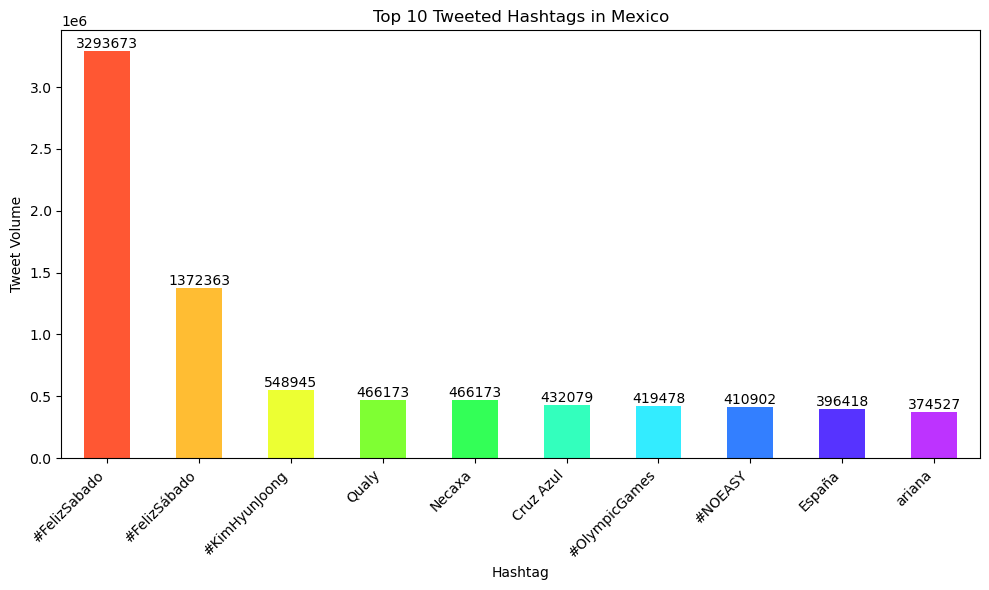

In [33]:

custom_colors = ['#FF5733', '#FFBD33', '#ECFF33', '#7FFF33', '#33FF57', '#33FFBD', '#33ECFF', '#337FFF', '#5733FF', '#BD33FF']


country_name = 'mexico'.lower()  

country_trends_all = all_trends[all_trends['searched_in_country'].str.lower() == country_name]
country_trends_hashtag = hashtag_trends[hashtag_trends['searched_in_country'].str.lower() == country_name]
country_trends_twitter = twitter_trending[twitter_trending['searched_hashtag_country'].str.lower() == country_name]

if country_trends_all.empty and country_trends_hashtag.empty and country_trends_twitter.empty:
    print(f"No records for {country_name.title()} found")
else:
    country_hashtag_volume_all = country_trends_all.groupby('trend_name')['tweet_volume'].sum()
    country_hashtag_volume_hashtag = country_trends_hashtag.groupby('trend_name')['tweet_volume'].sum()
    country_hashtag_volume_twitter = country_trends_twitter.groupby('tweet_hashtags')['retweet_count'].count()

    country_hashtag_volume = pd.concat([country_hashtag_volume_all, country_hashtag_volume_hashtag, country_hashtag_volume_twitter], axis=1).sum(axis=1)
    country_hashtag_volume_sorted = country_hashtag_volume.sort_values(ascending=False)

  
    plt.figure(figsize=(10, 6))
    bar_plot = country_hashtag_volume_sorted.head(10).plot(kind='bar', color=custom_colors)
    plt.xlabel('Hashtag')
    plt.ylabel('Tweet Volume')
    plt.title(f'Top 10 Tweeted Hashtags in {country_name.title()}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for i, value in enumerate(country_hashtag_volume_sorted.head(10)):
        bar_plot.text(i, value, str(int(value)), ha='center', va='bottom')

    plt.savefig(os.path.join(plots, f'Top 10 Tweeted Hashtags in {country_name.title()}'))
    plt.show()


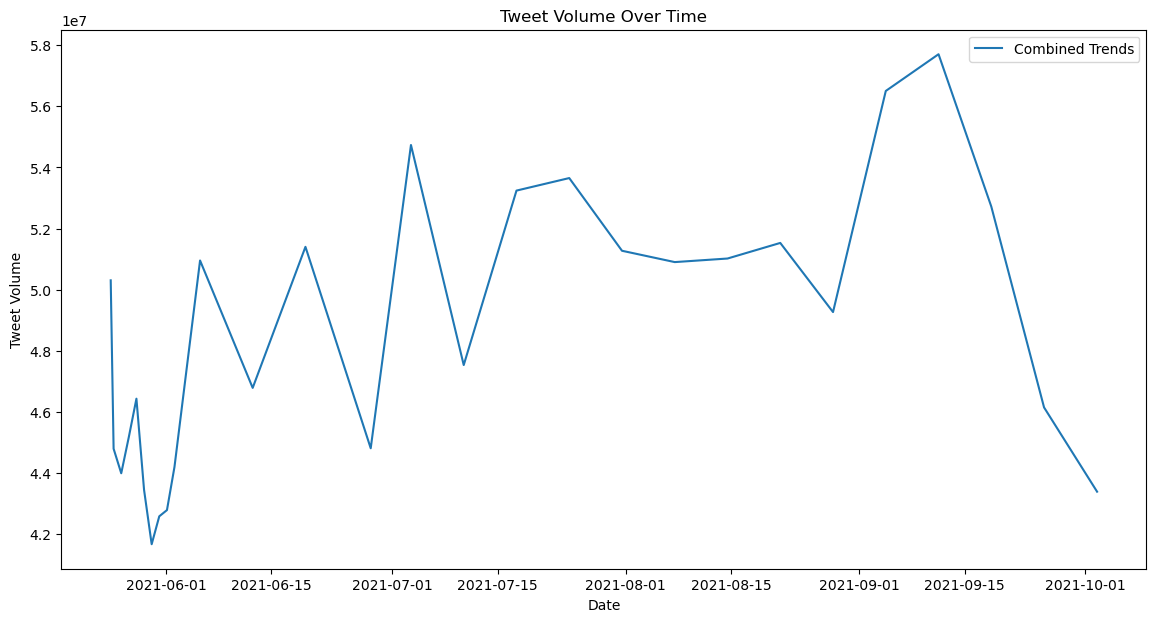

In [34]:
# Ensure 'searched_at_datetime' is in datetime format
all_trends['searched_at_datetime'] = pd.to_datetime(all_trends['searched_at_datetime'])
hashtag_trends['searched_at_datetime'] = pd.to_datetime(hashtag_trends['searched_at_datetime'])


combined_trends = pd.concat([all_trends, hashtag_trends])

combined_trends_grouped = combined_trends.groupby('searched_at_datetime')['tweet_volume'].sum()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(combined_trends_grouped, label='Combined Trends')
plt.title('Tweet Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Volume')
plt.legend()  # Add legend
plt.savefig(os.path.join(plots, 'tweet_volume_over_time.png'))
plt.show()

In [35]:

train_df, test_df = train_test_split(twitter_trending, test_size=0.3, random_state=42)

def textblob_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity


analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(tweet):
    scores = analyzer.polarity_scores(tweet)
    return scores['compound']


train_df['textblob_polarity'] = train_df['Text_No_Stopwords'].apply(textblob_sentiment)
train_df['vader_polarity'] = train_df['Text_No_Stopwords'].apply(vader_sentiment)

test_df['textblob_polarity'] = test_df['Text_No_Stopwords'].apply(textblob_sentiment)
test_df['vader_polarity'] = test_df['Text_No_Stopwords'].apply(vader_sentiment)


def categorize_sentiment(polarity):
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

train_df['textblob_sentiment_category'] = train_df['textblob_polarity'].apply(categorize_sentiment)
train_df['vader_sentiment_category'] = train_df['vader_polarity'].apply(categorize_sentiment)

test_df['textblob_sentiment_category'] = test_df['textblob_polarity'].apply(categorize_sentiment)
test_df['vader_sentiment_category'] = test_df['vader_polarity'].apply(categorize_sentiment)



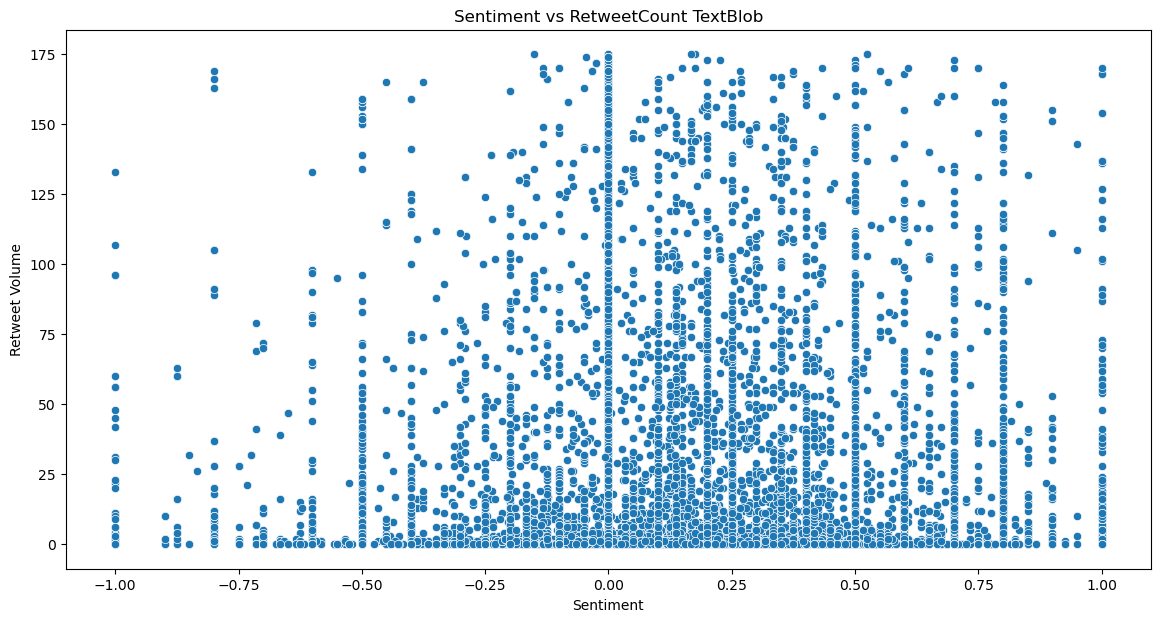

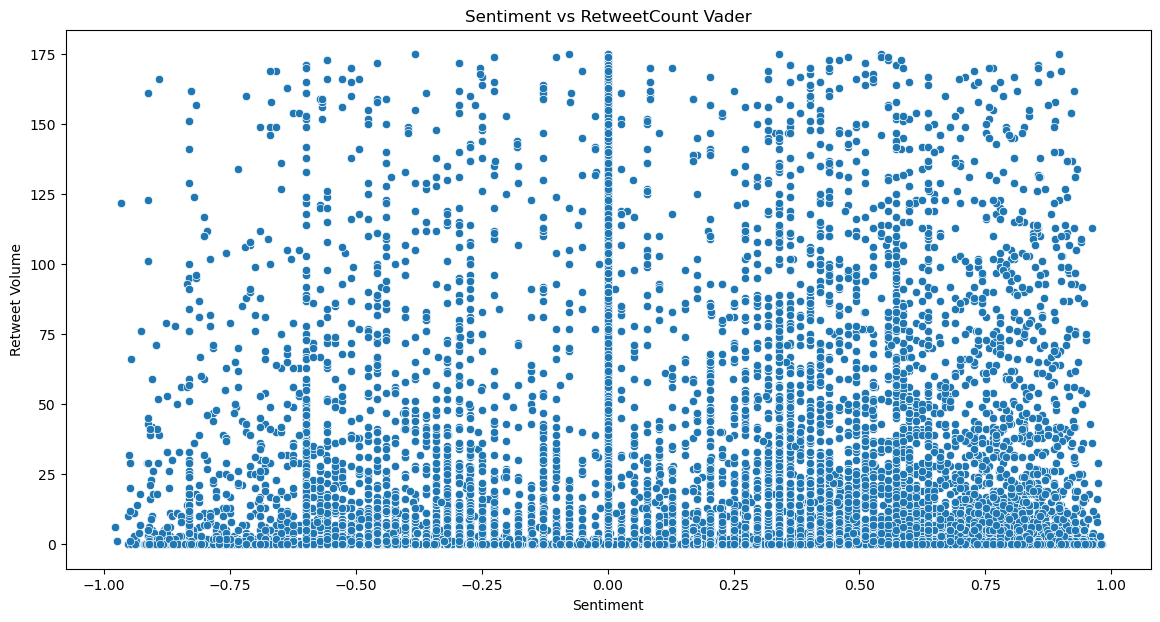

In [36]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='textblob_polarity', y='retweet_count', data=train_df)
plt.title('Sentiment vs RetweetCount TextBlob')
plt.xlabel('Sentiment')
plt.ylabel('Retweet Volume')
plt.savefig(os.path.join(plots, 'sentiment_vs_retweet_TextBlob.png'))
plt.show()

plt.figure(figsize=(14, 7))
sns.scatterplot(x='vader_polarity', y='retweet_count', data=train_df)
plt.title('Sentiment vs RetweetCount Vader')
plt.xlabel('Sentiment')
plt.ylabel('Retweet Volume')
plt.savefig(os.path.join(plots, 'sentiment_vs_retweet_Vader.png'))
plt.show()

In [37]:
#Modelling 

In [38]:


# Prepare data for TextBlob classification
X_train_textblob = train_df['Text_No_Stopwords']
y_train_textblob = train_df['textblob_sentiment_category']
X_test_textblob = test_df['Text_No_Stopwords']
y_test_textblob = test_df['textblob_sentiment_category']
 

# Prepare data for VADER classification
X_train_vader = train_df['Text_No_Stopwords']
y_train_vader = train_df['vader_sentiment_category']
X_test_vader = test_df['Text_No_Stopwords']
y_test_vader = test_df['vader_sentiment_category']

vectorizer = CountVectorizer()


X_train_vectorized_textblob = vectorizer.fit_transform(X_train_textblob)
X_test_vectorized_textblob = vectorizer.transform(X_test_textblob)

X_train_vectorized_vader = vectorizer.fit_transform(X_train_vader)
X_test_vectorized_vader = vectorizer.transform(X_test_vader)

# Encode labels for TextBlob
label_encoder_textblob = LabelEncoder()
y_train_encoded_textblob = label_encoder_textblob.fit_transform(y_train_textblob)
y_test_encoded_textblob = label_encoder_textblob.transform(y_test_textblob)

# Encode labels for VADER
label_encoder_vader = LabelEncoder()
y_train_encoded_vader = label_encoder_vader.fit_transform(y_train_vader)
y_test_encoded_vader = label_encoder_vader.transform(y_test_vader)


classifier_textblob = LinearSVC()
classifier_textblob.fit(X_train_vectorized_textblob, y_train_encoded_textblob)


classifier_vader = LinearSVC()
classifier_vader.fit(X_train_vectorized_vader, y_train_encoded_vader)


y_pred_textblob = classifier_textblob.predict(X_test_vectorized_textblob)

y_pred_vader = classifier_vader.predict(X_test_vectorized_vader)


accuracy_textblob = accuracy_score(y_test_encoded_textblob, y_pred_textblob)
print("TextBlob LinearSVC Accuracy:", accuracy_textblob)


accuracy_vader = accuracy_score(y_test_encoded_vader, y_pred_vader)
print("VADER LinearSVC Accuracy:", accuracy_vader)



output_file = os.path.join(datas, "LinearSVC_classification_results.txt")

with open(output_file, "w") as f:
    f.write(f"TextBlob LinearSVC Accuracy: {accuracy_textblob}\n")
    f.write(f"VADER LinearSVC Accuracy: {accuracy_vader}\n")



/Users/lancecerejo/opt/anaconda3/envs/DMAT/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/lancecerejo/opt/anaconda3/envs/DMAT/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


TextBlob LinearSVC Accuracy: 0.9704707249745751
VADER LinearSVC Accuracy: 0.9547798924887404


In [39]:
#The TextBlob LinearSVC model achieved an accuracy of approximately 97.05%, while the VADER LinearSVC model achieved around 95.48% accuracy.
#These accuracies suggest that both models are performing well in classifying sentiment from your data.

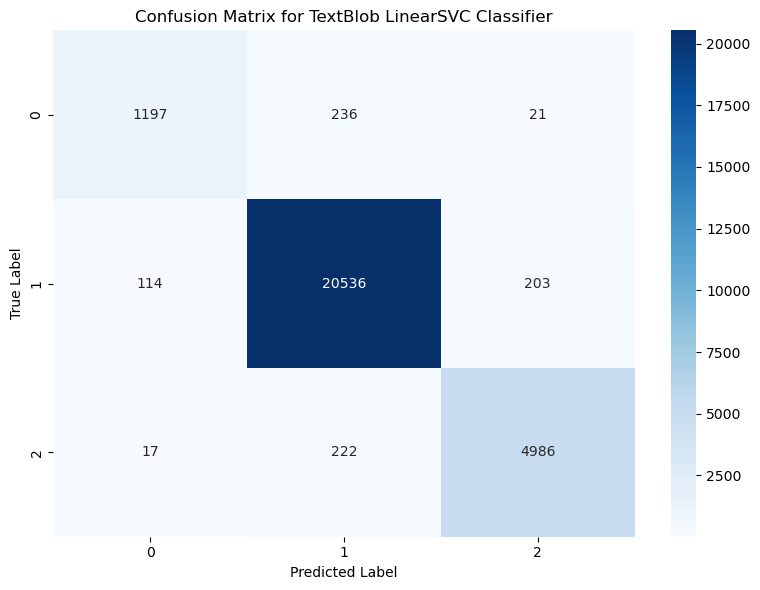

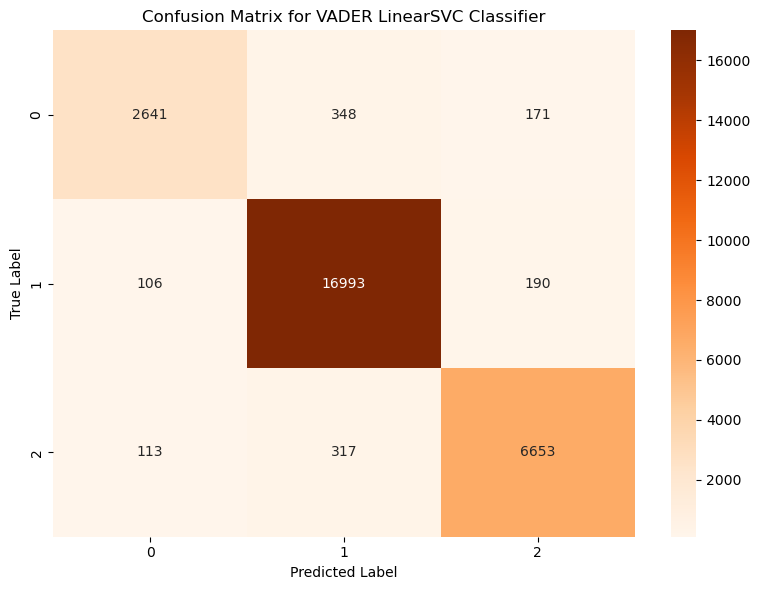

In [40]:
# Compute confusion matrix for TextBlob
conf_matrix_textblob = confusion_matrix(y_test_encoded_textblob, y_pred_textblob)

# Compute confusion matrix for VADER
conf_matrix_vader = confusion_matrix(y_test_encoded_vader, y_pred_vader)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_textblob, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for TextBlob LinearSVC Classifier')
plt.tight_layout()
plt.savefig(os.path.join(plots, 'Confusion Matrix for TextBlob LinearSVC Classifier.png'))
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_vader, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VADER LinearSVC Classifier')
plt.tight_layout()
plt.savefig(os.path.join(plots, 'Confusion Matrix for VADER LinearSVC Classifier.png'))
plt.show()

In [41]:
X_train = train_df['Text_No_Stopwords']
y_train_textblob = train_df['textblob_polarity']
y_train_vader = train_df['vader_polarity']

X_test = test_df['Text_No_Stopwords']
y_test_textblob = test_df['textblob_polarity']
y_test_vader = test_df['vader_polarity']


vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

dt_reg_textblob = DecisionTreeRegressor()
dt_reg_textblob.fit(X_train_vectorized, y_train_textblob)

dt_reg_vader = DecisionTreeRegressor()
dt_reg_vader.fit(X_train_vectorized, y_train_vader)

# Predictions for TextBlob regression
dt_reg_textblob_pred = dt_reg_textblob.predict(X_test_vectorized)

# Predictions for VADER regression
dt_reg_vader_pred = dt_reg_vader.predict(X_test_vectorized)

dt_reg_textblob_rmse = np.sqrt(mean_squared_error(y_test_textblob, dt_reg_textblob_pred))

dt_reg_vader_rmse = np.sqrt(mean_squared_error(y_test_vader, dt_reg_vader_pred))


output_file = os.path.join(datas, "DecisionTreeRegressor_results.txt")

with open(output_file, "w") as f:
    f.write(f'TextBlob Decision Tree Regression RMSE: {dt_reg_textblob_rmse}\n')
    f.write(f'VADER Decision Tree Regression RMSE: {dt_reg_vader_rmse}\n')

print(f'TextBlob Decision Tree Regression RMSE: {dt_reg_textblob_rmse}')
print(f'VADER Decision Tree Regression RMSE: {dt_reg_vader_rmse}')


TextBlob Decision Tree Regression RMSE: 0.08150722305969661
VADER Decision Tree Regression RMSE: 0.1287916716618442


In [42]:
# the TextBlob-based regression model seems to perform slightly better in predicting sentiment polarity compared to the VADER-based regression model.

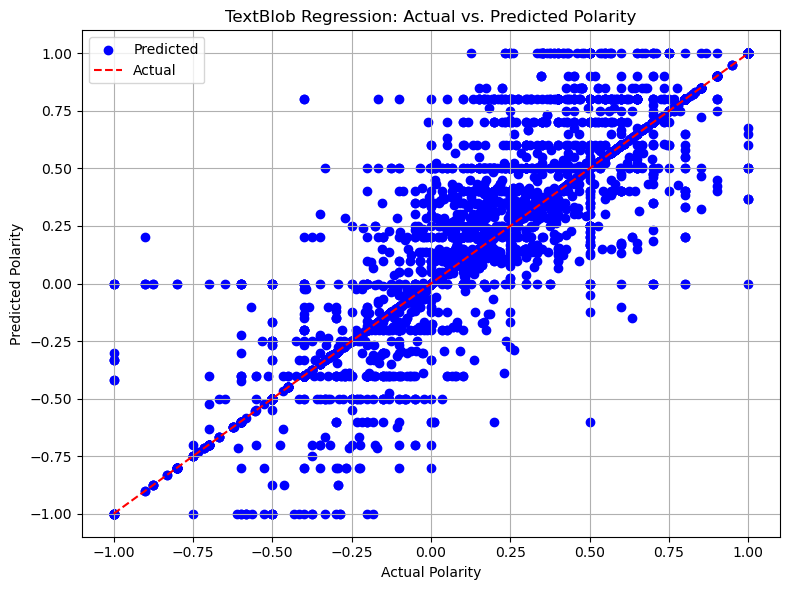

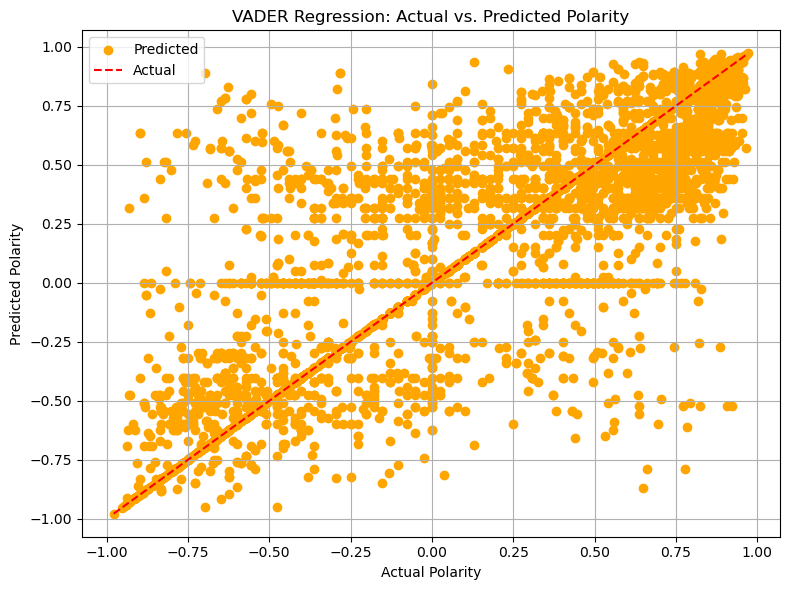

In [43]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test_textblob, dt_reg_textblob_pred, color='blue', label='Predicted')
plt.plot([min(y_test_textblob), max(y_test_textblob)], [min(y_test_textblob), max(y_test_textblob)], color='red', linestyle='--', label='Actual')
plt.title('TextBlob Regression: Actual vs. Predicted Polarity')
plt.xlabel('Actual Polarity')
plt.ylabel('Predicted Polarity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots, 'TextBlob Regression: Actual vs. Predicted Polarity.png'))
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(y_test_vader, dt_reg_vader_pred, color='orange', label='Predicted')
plt.plot([min(y_test_vader), max(y_test_vader)], [min(y_test_vader), max(y_test_vader)], color='red', linestyle='--', label='Actual')
plt.title('VADER Regression: Actual vs. Predicted Polarity')
plt.xlabel('Actual Polarity')
plt.ylabel('Predicted Polarity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots, 'VADER Regression: Actual vs. Predicted Polarity.png'))
plt.show()

In [44]:
# The closer the points are to a straight line, the better the model’s predictions.
#This helps in evaluating the performance of the model and seeing how close the predicted results are to the actual values.

In [45]:

# Prepare data for classification with TextBlob sentiment labels
X_train_textblob = train_df['Text_No_Stopwords']
y_train_textblob = train_df['textblob_sentiment_category']
X_test_textblob = test_df['Text_No_Stopwords']
y_test_textblob = test_df['textblob_sentiment_category']

# Prepare data for classification with VADER sentiment labels
X_train_vader = train_df['Text_No_Stopwords']
y_train_vader = train_df['vader_sentiment_category']
X_test_vader = test_df['Text_No_Stopwords']
y_test_vader = test_df['vader_sentiment_category']

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the tweet text for TextBlob
X_train_vectorized_textblob = vectorizer.fit_transform(X_train_textblob)
X_test_vectorized_textblob = vectorizer.transform(X_test_textblob)

# Fit and transform the tweet text for VADER
X_train_vectorized_vader = vectorizer.fit_transform(X_train_vader)
X_test_vectorized_vader = vectorizer.transform(X_test_vader)

# Encode labels for TextBlob
label_encoder_textblob = LabelEncoder()
y_train_encoded_textblob = label_encoder_textblob.fit_transform(y_train_textblob)
y_test_encoded_textblob = label_encoder_textblob.transform(y_test_textblob)

# Encode labels for VADER
label_encoder_vader = LabelEncoder()
y_train_encoded_vader = label_encoder_vader.fit_transform(y_train_vader)
y_test_encoded_vader = label_encoder_vader.transform(y_test_vader)

# Initialize and train the Random Forest classifier for TextBlob
classifier_rf_textblob = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_rf_textblob.fit(X_train_vectorized_textblob, y_train_encoded_textblob)

# Initialize and train the Random Forest classifier for VADER
classifier_rf_vader = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_rf_vader.fit(X_train_vectorized_vader, y_train_encoded_vader)

# Predict the sentiment on the test set for TextBlob
y_pred_rf_textblob = classifier_rf_textblob.predict(X_test_vectorized_textblob)

# Predict the sentiment on the test set for VADER
y_pred_rf_vader = classifier_rf_vader.predict(X_test_vectorized_vader)

# Calculate the accuracy for TextBlob
accuracy_rf_textblob = accuracy_score(y_test_encoded_textblob, y_pred_rf_textblob)
print("Random Forest Classifier Accuracy (TextBlob):", accuracy_rf_textblob)

# Calculate the accuracy for VADER
accuracy_rf_vader = accuracy_score(y_test_encoded_vader, y_pred_rf_vader)
print("Random Forest Classifier Accuracy (VADER):", accuracy_rf_vader)


# Save both results into one file
output_file = os.path.join(datas, "Random Forest Classifier_results.txt")

with open(output_file, "w") as f:
    f.write(f"Random Forest Classifier accuracy Textblob: {accuracy_rf_textblob}\n")
    f.write(f"Random Forest Classifier accuracy Vader: {accuracy_rf_vader}\n")

Random Forest Classifier Accuracy (TextBlob): 0.9657126253087317
Random Forest Classifier Accuracy (VADER): 0.9404329507482202


In [46]:
# the random forest classifiers for sentiment classification, utilizing TextBlob and VADER, exhibit robust accuracy in determining sentiment labels from your data.

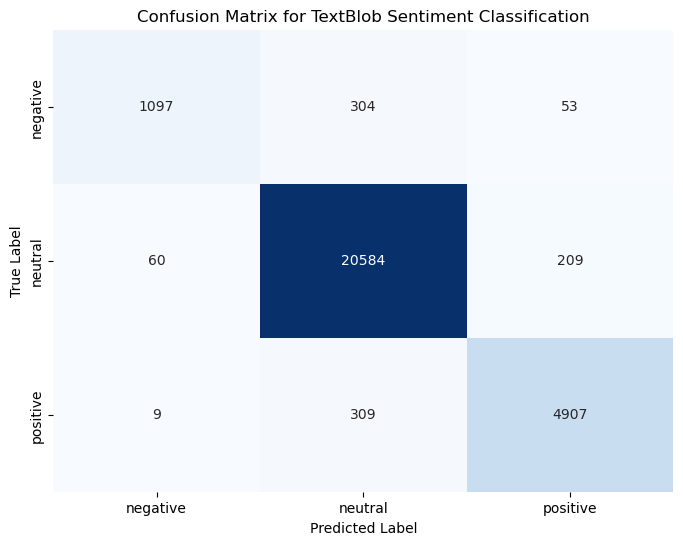

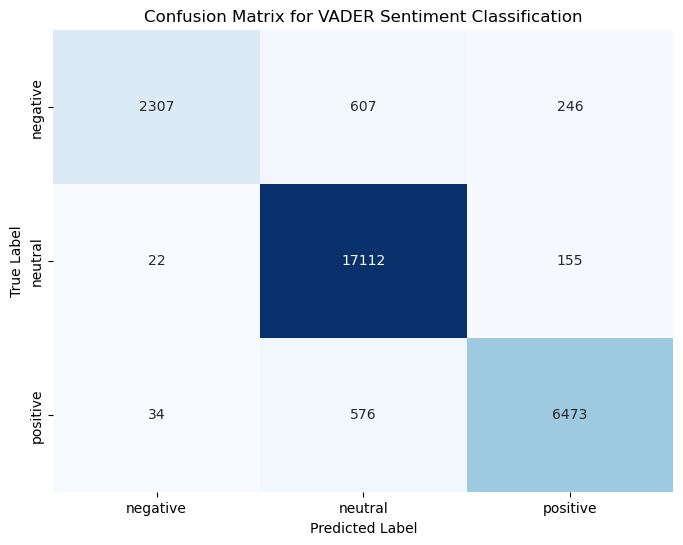

In [47]:

conf_matrix_textblob = confusion_matrix(y_test_encoded_textblob, y_pred_rf_textblob)

conf_matrix_vader = confusion_matrix(y_test_encoded_vader, y_pred_rf_vader)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_textblob, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder_textblob.classes_, yticklabels=label_encoder_textblob.classes_)
plt.title('Confusion Matrix for TextBlob Sentiment Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(plots, 'Confusion Matrix for TextBlob Sentiment Classification.png'))
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_vader, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder_vader.classes_, yticklabels=label_encoder_vader.classes_)
plt.title('Confusion Matrix for VADER Sentiment Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(plots, 'Confusion Matrix for VADER Sentiment Classification.png'))

plt.show()

In [50]:
X_train = train_df['Text_No_Stopwords']
y_train_textblob = train_df['textblob_polarity']
y_train_vader = train_df['vader_polarity']

X_test = test_df['Text_No_Stopwords']
y_test_textblob = test_df['textblob_polarity']
y_test_vader = test_df['vader_polarity']

vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train Random Forest Regressor for TextBlob polarity
rf_reg_textblob = RandomForestRegressor(n_estimators=10)
rf_reg_textblob.fit(X_train_vectorized, y_train_textblob)

# Train Random Forest Regressor for VADER polarity
rf_reg_vader = RandomForestRegressor(n_estimators=10)
rf_reg_vader.fit(X_train_vectorized, y_train_vader)

# Predictions for TextBlob regression
rf_reg_textblob_pred = rf_reg_textblob.predict(X_test_vectorized)

# Predictions for VADER regression
rf_reg_vader_pred = rf_reg_vader.predict(X_test_vectorized)

# Calculate RMSE for TextBlob regression
rf_reg_textblob_rmse = np.sqrt(mean_squared_error(y_test_textblob, rf_reg_textblob_pred))

# Calculate RMSE for VADER regression
rf_reg_vader_rmse = np.sqrt(mean_squared_error(y_test_vader, rf_reg_vader_pred))

output_file = os.path.join(datas, "RandomForestRegressor_results.txt")

# Write results to a file
with open(output_file, "w") as f:
    f.write(f'TextBlob Random Forest Regression RMSE: {rf_reg_textblob_rmse}\n')
    f.write(f'VADER Random Forest Regression RMSE: {rf_reg_vader_rmse}\n')

# Print RMSE
print(f'TextBlob Random Forest Regression RMSE: {rf_reg_textblob_rmse}')
print(f'VADER Random Forest Regression RMSE: {rf_reg_vader_rmse}')

TextBlob Random Forest Regression RMSE: 0.07697922488330476
VADER Random Forest Regression RMSE: 0.12145092028952517


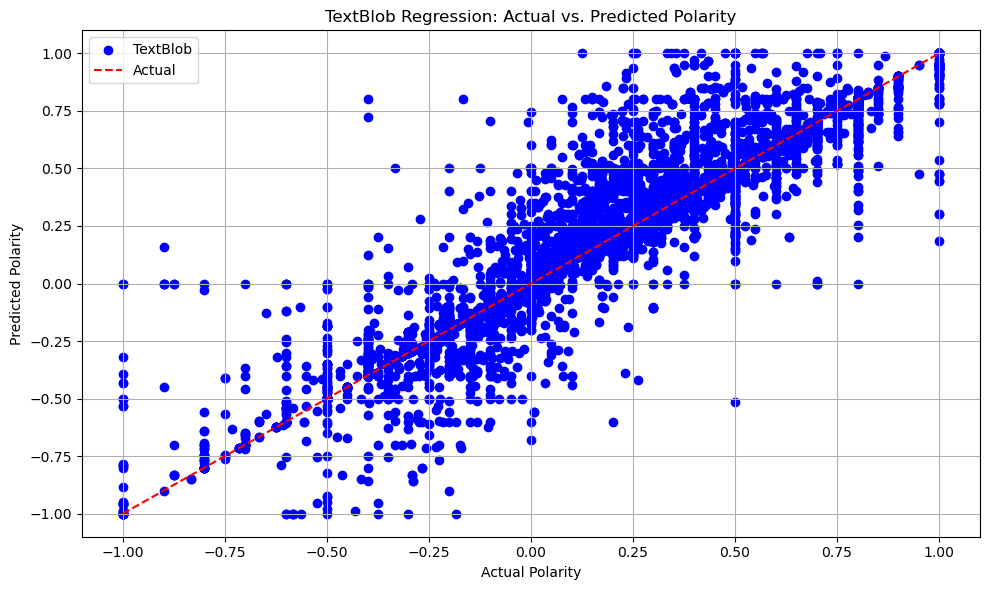

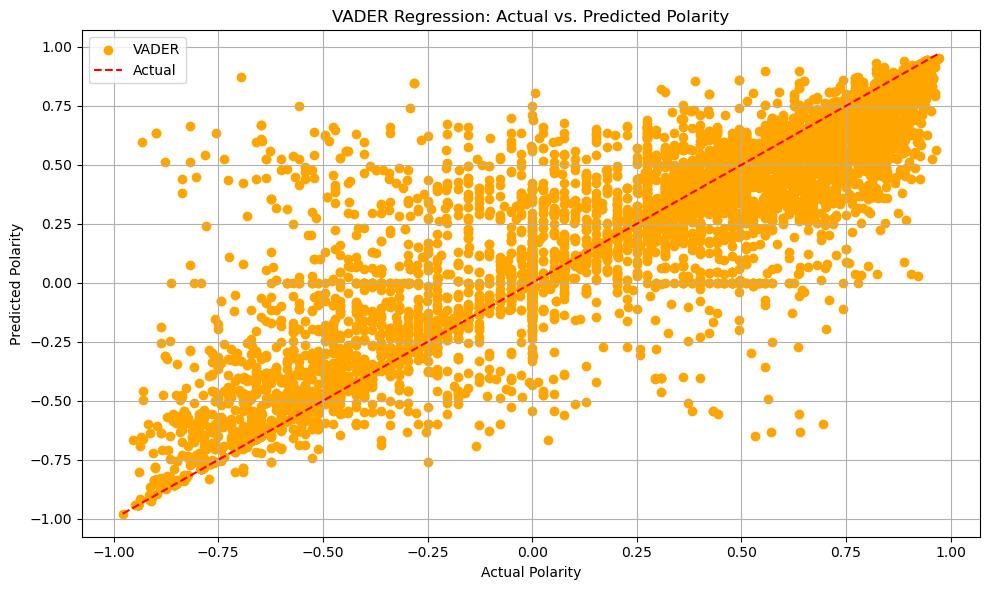

In [51]:
# Create scatter plot for TextBlob regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_textblob, rf_reg_textblob_pred, color='blue', label='TextBlob')
plt.plot([min(y_test_textblob), max(y_test_textblob)], [min(y_test_textblob), max(y_test_textblob)], color='red', linestyle='--', label='Actual')
plt.title('TextBlob Regression: Actual vs. Predicted Polarity')
plt.xlabel('Actual Polarity')
plt.ylabel('Predicted Polarity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots, 'TextBlob_Regression_Actual_vs_Predicted_Polarity.png'))
plt.show()

# Create scatter plot for VADER regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_vader, rf_reg_vader_pred, color='orange', label='VADER')
plt.plot([min(y_test_vader), max(y_test_vader)], [min(y_test_vader), max(y_test_vader)], color='red', linestyle='--', label='Actual')
plt.title('VADER Regression: Actual vs. Predicted Polarity')
plt.xlabel('Actual Polarity')
plt.ylabel('Predicted Polarity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots, 'VADER_Regression_Actual_vs_Predicted_Polarity.png'))
plt.show()

In [ ]:
#This helps in evaluating the performance of the model and seeing how close the predicted results are to the actual values.